# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [96]:
import gc
import string
import re
from collections import Counter
import numpy as np
gc.collect()
import nltk
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))
len(STOP_WORDS)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
from numpy.random import choice

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print (torch.cuda.get_device_name(0))

GeForce GTX 1050 Ti


_______________________________

In [97]:
class Batcher:
    def __init__(self, max_len, window_size, corpus_path, min_freq, max_freq, max_voc_size, batch_size):
        self.corpus_path = corpus_path
        self.window_size = window_size
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.max_voc_size = max_voc_size
        self.batch_size = batch_size
        self.max_len = max_len
        self.words = None
        self.word2index = None
        self.index2word = None
        self.freq = None
        self.voc = None
        self.voc_size = None
        self.corpus = None
        self.corpus_size = None
        
        
    def read_data(self, S):
        if S == None:
            with open(self.corpus_path, 'r') as f:
                S = f.read()
            if S!=None:
                S = S.lower()[: self.max_len]
        print('Len of S = ', len(S))
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        S = regex.sub(' ', S)
        words_raw = list(S.split())
        print(len(words_raw))
        words = []
        for word in words_raw:
            if word in STOP_WORDS:
                pass
            else:
                words.append(word)

        print('Size of words = ', len(words))
        counter = Counter(words)
        print('Size of counter = ', len(counter))
        if self.min_freq != None:
            counter = {x : counter[x] for x in counter if counter[x] >= self.min_freq}
        print('Size of counter after min_freq = ', len(counter))
        if self.max_freq != None:
            counter = {x : counter[x] for x in counter if counter[x] <= self.max_freq}
        print('Size of counter after max_freq = ', len(counter))
        counter = Counter(counter)

        freq = dict(counter.most_common(self.max_voc_size))
        voc = set(freq)
        
        unk = set(words).difference(voc)
        print('Size of freq dict = ', len(voc))
        print('Number of vocabulary words = ', len(voc))
        print('Number of unknown words = ', len(unk))

        words = ['UNK' if word in unk else word for word in words]        
        if len(words)%self.batch_size == 0:
            padding = self.window_size
        else:
            padding = self.batch_size - len(words)%self.batch_size + self.window_size
            
        words = ['PAD']*self.window_size + words + ['PAD']*padding
        unique_words = list(set(words))
        print('Size of corpus = ', len(words))
        print('Size of vocabulary = ', len(unique_words))
        self.word2index = {k: v for v, k in enumerate(unique_words)}
        self.index2word = {v: k for v, k in enumerate(unique_words)}
        words = [self.word2index[word] for word in words]
        self.freq = Counter(words)
        self.voc = set(self.freq)
        self.voc_size = len(self.voc)
        self.corpus = words
        self.corpus_size = len(words)
    
    def generator(self):
        i = self.window_size
        x_batch = []
        y_batch = []
        
        while i < self.corpus_size-self.window_size:
            if len(x_batch)==self.batch_size:
                x_batch = []
                y_batch = []
                
            x = self.corpus[i-self.window_size: i] + self.corpus[i+1: i+self.window_size+1]
#             y = [0]*self.voc_size
#             y[self.corpus[i]] = 1
            y = [self.corpus[i]]*self.window_size*2
            x_batch.append(x)
            y_batch.append(y)
            i += 1
            if len(x_batch)==self.batch_size:
                yield np.array(x_batch), np.array(y_batch)

In [98]:
BATCH_SIZE = 8192
#MAX_LEN = 10000000
MAX_LEN = 100000000000
batcher = Batcher(max_len=MAX_LEN, window_size=2, corpus_path='text8', min_freq=5, max_freq=None, max_voc_size=10000000, batch_size=BATCH_SIZE)
batcher.read_data(S=None)

Len of S =  100000000
17005207
Size of words =  10890638
Size of counter =  253702
Size of counter after min_freq =  71140
Size of counter after max_freq =  71140
Size of freq dict =  71140
Number of vocabulary words =  71140
Number of unknown words =  182562
Size of corpus =  10895364
Size of vocabulary =  71142


In [99]:
for x, y in batcher.generator():
    print(x.shape, y.shape)
    break

(8192, 4) (8192, 4)


In [100]:
for x, y in batcher.generator():
    for i in range(x.shape[0]):
        target_word = y[i][0]
        for j in range(x.shape[1]):
            context_word = x[i][j]
            print(batcher.index2word[target_word], batcher.index2word[context_word])
    break

anarchism PAD
anarchism PAD
anarchism originated
anarchism term
originated PAD
originated anarchism
originated term
originated abuse
term anarchism
term originated
term abuse
term first
abuse originated
abuse term
abuse first
abuse used
first term
first abuse
first used
first early
used abuse
used first
used early
used working
early first
early used
early working
early class
working used
working early
working class
working radicals
class early
class working
class radicals
class including
radicals working
radicals class
radicals including
radicals diggers
including class
including radicals
including diggers
including english
diggers radicals
diggers including
diggers english
diggers revolution
english including
english diggers
english revolution
english sans
revolution diggers
revolution english
revolution sans
revolution culottes
sans english
sans revolution
sans culottes
sans french
culottes revolution
culottes sans
culottes french
culottes revolution
french sans
french culottes
frenc

work opposed
work institution
opposed theft
opposed work
opposed institution
opposed decreed
institution work
institution opposed
institution decreed
institution property
decreed opposed
decreed institution
decreed property
decreed propri
property institution
property decreed
property propri
property owners
propri decreed
propri property
propri owners
propri complete
owners property
owners propri
owners complete
owners rights
complete propri
complete owners
complete rights
complete use
rights owners
rights complete
rights use
rights abuse
use complete
use rights
use abuse
use property
abuse rights
abuse use
abuse property
abuse wish
property use
property abuse
property wish
property exploiting
wish abuse
wish property
wish exploiting
wish workers
exploiting property
exploiting wish
exploiting workers
exploiting profit
workers wish
workers exploiting
workers profit
workers place
profit exploiting
profit workers
profit place
profit proudhon
place workers
place profit
place proudhon
place

first became
international eight
international first
international became
international polarised
became first
became international
became polarised
became two
polarised international
polarised became
polarised two
polarised camps
two became
two polarised
two camps
two marx
camps polarised
camps two
camps marx
camps bakunin
marx two
marx camps
marx bakunin
marx respective
bakunin camps
bakunin marx
bakunin respective
bakunin UNK
respective marx
respective bakunin
respective UNK
respective clearest
UNK bakunin
UNK respective
UNK clearest
UNK difference
clearest respective
clearest UNK
clearest difference
clearest camps
difference UNK
difference clearest
difference camps
difference strategy
camps clearest
camps difference
camps strategy
camps anarchists
strategy difference
strategy camps
strategy anarchists
strategy around
anarchists camps
anarchists strategy
anarchists around
anarchists bakunin
around strategy
around anarchists
around bakunin
around favoured
bakunin anarchists
bakunin a

century class
working th
working century
working class
working movement
class century
class working
class movement
class seeking
movement working
movement class
movement seeking
movement overthrow
seeking class
seeking movement
seeking overthrow
seeking capitalism
overthrow movement
overthrow seeking
overthrow capitalism
overthrow state
capitalism seeking
capitalism overthrow
capitalism state
capitalism institute
state overthrow
state capitalism
state institute
state worker
institute capitalism
institute state
institute worker
institute controlled
worker state
worker institute
worker controlled
worker society
controlled institute
controlled worker
controlled society
controlled movement
society worker
society controlled
society movement
society pursued
movement controlled
movement society
movement pursued
movement industrial
pursued society
pursued movement
pursued industrial
pursued actions
industrial movement
industrial pursued
industrial actions
industrial general
actions pursued
act

one nine
one one
nine culminated
nine one
nine one
nine eight
one one
one nine
one eight
one kronstadt
eight nine
eight one
eight kronstadt
eight rebellion
kronstadt one
kronstadt eight
kronstadt rebellion
kronstadt anarchists
rebellion eight
rebellion kronstadt
rebellion anarchists
rebellion central
anarchists kronstadt
anarchists rebellion
anarchists central
anarchists russia
central rebellion
central anarchists
central russia
central imprisoned
russia anarchists
russia central
russia imprisoned
russia driven
imprisoned central
imprisoned russia
imprisoned driven
imprisoned underground
driven russia
driven imprisoned
driven underground
driven joined
underground imprisoned
underground driven
underground joined
underground victorious
joined driven
joined underground
joined victorious
joined bolsheviks
victorious underground
victorious joined
victorious bolsheviks
victorious ukraine
bolsheviks joined
bolsheviks victorious
bolsheviks ukraine
bolsheviks anarchists
ukraine victorious
ukrai

anarchist tends
culture zero
culture anarchist
culture tends
culture secular
tends anarchist
tends culture
tends secular
tends outright
secular culture
secular tends
secular outright
secular anti
outright tends
outright secular
outright anti
outright religious
anti secular
anti outright
anti religious
anti however
religious outright
religious anti
religious however
religious combination
however anti
however religious
however combination
however religious
combination religious
combination however
combination religious
combination social
religious however
religious combination
religious social
religious conscience
social combination
social religious
social conscience
social historical
conscience religious
conscience social
conscience historical
conscience UNK
historical social
historical conscience
historical UNK
historical amongst
UNK conscience
UNK historical
UNK amongst
UNK oppressed
amongst historical
amongst UNK
amongst oppressed
amongst social
oppressed UNK
oppressed amongst
oppres

feminist helped
reader anarcha
reader feminist
reader helped
reader spread
helped feminist
helped reader
helped spread
helped various
spread reader
spread helped
spread various
spread kinds
various helped
various spread
various kinds
various anti
kinds spread
kinds various
kinds anti
kinds authoritarian
anti various
anti kinds
anti authoritarian
anti anarchist
authoritarian kinds
authoritarian anti
authoritarian anarchist
authoritarian feminist
anarchist anti
anarchist authoritarian
anarchist feminist
anarchist ideas
feminist authoritarian
feminist anarchist
feminist ideas
feminist broader
ideas anarchist
ideas feminist
ideas broader
ideas movement
broader feminist
broader ideas
broader movement
broader wendy
movement ideas
movement broader
movement wendy
movement mcelroy
wendy broader
wendy movement
wendy mcelroy
wendy popularized
mcelroy movement
mcelroy wendy
mcelroy popularized
mcelroy individualist
popularized wendy
popularized mcelroy
popularized individualist
popularized anarchi

war causes
war anti
war anti
war nuclear
anti anti
anti war
anti nuclear
anti etc
nuclear war
nuclear anti
nuclear etc
nuclear calls
etc anti
etc nuclear
etc calls
etc synthesis
calls nuclear
calls etc
calls synthesis
calls anarchist
synthesis etc
synthesis calls
synthesis anarchist
synthesis thought
anarchist calls
anarchist synthesis
anarchist thought
anarchist specifically
thought synthesis
thought anarchist
thought specifically
thought anti
specifically anarchist
specifically thought
specifically anti
specifically authoritarian
anti thought
anti specifically
anti authoritarian
anti revolutionary
authoritarian specifically
authoritarian anti
authoritarian revolutionary
authoritarian movement
revolutionary anti
revolutionary authoritarian
revolutionary movement
revolutionary outside
movement authoritarian
movement revolutionary
movement outside
movement leftist
outside revolutionary
outside movement
outside leftist
outside milieu
leftist movement
leftist outside
leftist milieu
leftis

anarchist many
group action
group anarchist
group many
group anarchists
many anarchist
many group
many anarchists
many involved
anarchists group
anarchists many
anarchists involved
anarchists focuses
involved many
involved anarchists
involved focuses
involved publicly
focuses anarchists
focuses involved
focuses publicly
focuses confronting
publicly involved
publicly focuses
publicly confronting
publicly racist
confronting focuses
confronting publicly
confronting racist
confronting agitators
racist publicly
racist confronting
racist agitators
racist zapatista
agitators confronting
agitators racist
agitators zapatista
agitators movement
zapatista racist
zapatista agitators
zapatista movement
zapatista chiapas
movement agitators
movement zapatista
movement chiapas
movement mexico
chiapas zapatista
chiapas movement
chiapas mexico
chiapas cultural
mexico movement
mexico chiapas
mexico cultural
mexico sovereignty
cultural chiapas
cultural mexico
cultural sovereignty
cultural group
sovereignt

see UNK
see e
see g
e UNK
e see
e g
e plekhanov
g see
g e
g plekhanov
g marxist
plekhanov e
plekhanov g
plekhanov marxist
plekhanov critique
marxist g
marxist plekhanov
marxist critique
marxist one
critique plekhanov
critique marxist
critique one
critique eight
one marxist
one critique
one eight
one nine
eight critique
eight one
eight nine
eight five
nine one
nine eight
nine five
nine anarchists
five eight
five nine
five anarchists
five also
anarchists nine
anarchists five
anarchists also
anarchists characterised
also five
also anarchists
also characterised
also UNK
characterised anarchists
characterised also
characterised UNK
characterised middle
UNK also
UNK characterised
UNK middle
UNK class
middle characterised
middle UNK
middle class
middle UNK
class UNK
class middle
class UNK
class recently
UNK middle
UNK class
UNK recently
UNK relation
recently class
recently UNK
recently relation
recently anti
relation UNK
relation recently
relation anti
relation capitalist
anti recently
anti r

ego max
ego stirner
ego leo
ego tolstoy
leo stirner
leo ego
leo tolstoy
leo kingdom
tolstoy ego
tolstoy leo
tolstoy kingdom
tolstoy god
kingdom leo
kingdom tolstoy
kingdom god
kingdom within
god tolstoy
god kingdom
god within
god anarchism
within kingdom
within god
within anarchism
within region
anarchism god
anarchism within
anarchism region
anarchism culture
region within
region anarchism
region culture
region african
culture anarchism
culture region
culture african
culture anarchism
african region
african culture
african anarchism
african anarchism
anarchism culture
anarchism african
anarchism anarchism
anarchism spain
anarchism african
anarchism anarchism
anarchism spain
anarchism anarchism
spain anarchism
spain anarchism
spain anarchism
spain english
anarchism anarchism
anarchism spain
anarchism english
anarchism tradition
english spain
english anarchism
english tradition
english chinese
tradition anarchism
tradition english
tradition chinese
tradition anarchism
chinese english
ch

patients behavioral
striking child
striking patients
striking behavioral
striking similarities
behavioral patients
behavioral striking
behavioral similarities
behavioral introduced
similarities striking
similarities behavioral
similarities introduced
similarities label
introduced behavioral
introduced similarities
introduced label
introduced early
label similarities
label introduced
label early
label infantile
early introduced
early label
early infantile
early autism
infantile label
infantile early
infantile autism
infantile suggested
autism early
autism infantile
autism suggested
autism autism
suggested infantile
suggested autism
suggested autism
suggested greek
autism autism
autism suggested
autism greek
autism autos
greek suggested
greek autism
greek autos
greek meaning
autos autism
autos greek
autos meaning
autos self
meaning greek
meaning autos
meaning self
meaning describe
self autos
self meaning
self describe
self fact
describe meaning
describe self
describe fact
describe childr

higher primates
higher adult
primates possibly
primates higher
primates adult
primates gorillas
adult higher
adult primates
adult gorillas
adult chimpanzees
gorillas primates
gorillas adult
gorillas chimpanzees
gorillas UNK
chimpanzees adult
chimpanzees gorillas
chimpanzees UNK
chimpanzees typical
UNK gorillas
UNK chimpanzees
UNK typical
UNK five
typical chimpanzees
typical UNK
typical five
typical year
five UNK
five typical
five year
five olds
year typical
year five
year olds
year develop
olds five
olds year
olds develop
olds insights
develop year
develop olds
develop insights
develop people
insights olds
insights develop
insights people
insights different
people develop
people insights
people different
people knowledge
different insights
different people
different knowledge
different feelings
knowledge people
knowledge different
knowledge feelings
knowledge intentions
feelings different
feelings knowledge
feelings intentions
feelings interpretations
intentions knowledge
intentions fe

song particular
repetitions sing
repetitions song
repetitions particular
repetitions calming
particular song
particular repetitions
particular calming
particular joyous
calming repetitions
calming particular
calming joyous
calming activity
joyous particular
joyous calming
joyous activity
joyous many
activity calming
activity joyous
activity many
activity autistic
many joyous
many activity
many autistic
many adults
autistic activity
autistic many
autistic adults
autistic engage
adults many
adults autistic
adults engage
adults many
engage autistic
engage adults
engage many
engage people
many adults
many engage
many people
many autism
people engage
people many
people autism
people strong
autism many
autism people
autism strong
autism tonal
strong people
strong autism
strong tonal
strong sense
tonal autism
tonal strong
tonal sense
tonal often
sense strong
sense tonal
sense often
sense understand
often tonal
often sense
often understand
often spoken
understand sense
understand often
underst

throughout day
throughout know
day going
day throughout
day know
day prepare
know throughout
know day
know prepare
know activity
prepare day
prepare know
prepare activity
prepare next
activity know
activity prepare
activity next
activity autistic
next prepare
next activity
next autistic
next children
autistic activity
autistic next
autistic children
autistic trouble
children next
children autistic
children trouble
children going
trouble autistic
trouble children
trouble going
trouble one
going children
going trouble
going one
going activity
one trouble
one going
one activity
one next
activity going
activity one
activity next
activity visual
next one
next activity
next visual
next schedule
visual activity
visual next
visual schedule
visual help
schedule next
schedule visual
schedule help
schedule reduce
help visual
help schedule
help reduce
help stress
reduce schedule
reduce help
reduce stress
reduce research
stress help
stress reduce
stress research
stress shown
research reduce
researc

criteria statement
criteria autism
criteria much
autism statement
autism criteria
autism much
autism controversial
much criteria
much autism
much controversial
much clinicians
controversial autism
controversial much
controversial clinicians
controversial today
clinicians much
clinicians controversial
clinicians today
clinicians may
today controversial
today clinicians
today may
today ignore
may clinicians
may today
may ignore
may completely
ignore today
ignore may
ignore completely
ignore instead
completely may
completely ignore
completely instead
completely solely
instead ignore
instead completely
instead solely
instead relying
solely completely
solely instead
solely relying
solely methods
relying instead
relying solely
relying methods
relying determining
methods solely
methods relying
methods determining
methods diagnosis
determining relying
determining methods
determining diagnosis
determining types
diagnosis methods
diagnosis determining
diagnosis types
diagnosis autism
types deter

california institute
california one
california seven
one institute
one california
one seven
one october
seven california
seven one
seven october
seven two
october one
october seven
october two
october zero
two seven
two october
two zero
two zero
zero october
zero two
zero zero
zero two
zero two
zero zero
zero two
zero claimed
two zero
two zero
two claimed
two increase
claimed zero
claimed two
claimed increase
claimed autism
increase two
increase claimed
increase autism
increase real
autism claimed
autism increase
autism real
autism even
real increase
real autism
real even
real complicating
even autism
even real
even complicating
even factors
complicating real
complicating even
complicating factors
complicating accounted
factors even
factors complicating
factors accounted
factors see
accounted complicating
accounted factors
accounted see
accounted reference
see factors
see accounted
see reference
see section
reference accounted
reference see
reference section
reference researchers
secti

socializing approaches
socializing educating
socializing autistics
socializing autistic
autistics educating
autistics socializing
autistics autistic
autistics culture
autistic socializing
autistic autistics
autistic culture
autistic begun
culture autistics
culture autistic
culture begun
culture develop
begun autistic
begun culture
begun develop
begun similar
develop culture
develop begun
develop similar
develop deaf
similar begun
similar develop
similar deaf
similar culture
deaf develop
deaf similar
deaf culture
deaf autistic
culture similar
culture deaf
culture autistic
culture culture
autistic deaf
autistic culture
autistic culture
autistic based
culture culture
culture autistic
culture based
culture belief
based autistic
based culture
based belief
based autism
belief culture
belief based
belief autism
belief unique
autism based
autism belief
autism unique
autism way
unique belief
unique autism
unique way
unique disorder
way autism
way unique
way disorder
way cured
disorder unique
di

development normal
development regression
development helps
regression normal
regression development
regression helps
regression differentiate
helps development
helps regression
helps differentiate
helps UNK
differentiate regression
differentiate helps
differentiate UNK
differentiate rett
UNK helps
UNK differentiate
UNK rett
UNK syndrome
rett differentiate
rett UNK
rett syndrome
rett fact
syndrome UNK
syndrome rett
syndrome fact
syndrome must
fact rett
fact syndrome
fact must
fact differentiated
must syndrome
must fact
must differentiated
must autism
differentiated fact
differentiated must
differentiated autism
differentiated testing
autism must
autism differentiated
autism testing
autism cause
testing differentiated
testing autism
testing cause
testing UNK
cause autism
cause testing
cause UNK
cause unknown
UNK testing
UNK cause
UNK unknown
UNK thus
unknown cause
unknown UNK
unknown thus
unknown may
thus UNK
thus unknown
thus may
thus spectrum
may unknown
may thus
may spectrum
may diso

one zero
zero zero
zero one
zero zero
zero important
zero one
zero zero
zero important
zero concept
important zero
important zero
important concept
important climatology
concept zero
concept important
concept climatology
concept astronomy
climatology important
climatology concept
climatology astronomy
climatology ratio
astronomy concept
astronomy climatology
astronomy ratio
astronomy depends
ratio climatology
ratio astronomy
ratio depends
ratio frequency
depends astronomy
depends ratio
depends frequency
depends radiation
frequency ratio
frequency depends
frequency radiation
frequency considered
radiation depends
radiation frequency
radiation considered
radiation unqualified
considered frequency
considered radiation
considered unqualified
considered refers
unqualified radiation
unqualified considered
unqualified refers
unqualified average
refers considered
refers unqualified
refers average
refers across
average unqualified
average refers
average across
average spectrum
across refers
acr

In [101]:
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_dim, window_size, batch_size):
        super(CBOW, self).__init__()
        self.embedding1 = nn.Embedding(voc_size, embedding_dim)
        self.embedding2 = nn.Embedding(voc_size, embedding_dim)
        
    def forward(self, target_word, context_word):

        target_word = torch.tensor(target_word).to(device='cuda')
#         print('target_word shape : ', target_word.shape)
        context_word = torch.tensor(context_word).to(device='cuda')
#         print('context_word shape : ', context_word.shape)
        target_emb = self.embedding1(target_word)
        context_emb = self.embedding2(context_word)
#         print('target_emb shape : ', target_emb.shape)
#         print('context_emb shape : ', context_emb.shape)
        
        z1 = torch.mul(target_emb, context_emb)
#         print('z1 shape : ', z1.shape)
        z2 = torch.sum(z1, dim=2)
#         print('z2 shape : ', z2.shape)
        pos_loss = torch.sum(F.logsigmoid(z2))
#         print('pos_loss shape : ', pos_loss.shape)
        
        neg_loss = 0
        for i in range(5):
            negative_word = choice(batcher.corpus, size=batcher.batch_size*batcher.window_size*2).reshape((batcher.batch_size, batcher.window_size*2))
            negative_word = torch.tensor(numpy.random.choice(batcher.corpus)).to(device='cuda')
            negative_emb = self.embedding2(negative_word)
            z4 = torch.mul(target_emb, negative_emb)
            z5 = torch.sum(z4, dim=2)
            z6 = torch.sum(F.logsigmoid(-z5))
            neg_loss += z6
        
        return -(pos_loss + neg_loss)

In [102]:
### ReduceLROnPlateau

losses = []
#loss_function = nn.NLLLoss()
model = CBOW(voc_size=batcher.voc_size, embedding_dim=256, window_size=batcher.window_size, batch_size=batcher.batch_size)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(optimizer = optimizer, \
                                 mode = 'min', \
                                 factor = 0.5, \
                                 threshold = 0.001 \
                                )

for epoch in range(10):
    print('========== Epoch {} =========='.format(epoch))
    total_loss = 0
    i = 0
    N = int(len(batcher.corpus)//BATCH_SIZE)
    for context, target in batcher.generator():
        model.train()

        loss = model(target, context)

        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        print('Batch {}/{} loss : {}'.format(i, N, loss/(BATCH_SIZE*batcher.window_size*2)), '\n')
        losses.append(loss)
        i += 1

========== Epoch 0 ==========
Batch 0/1330 loss : 37.47294235229492 

Batch 1/1330 loss : 39.04890060424805 

Batch 2/1330 loss : 39.21211624145508 

Batch 3/1330 loss : 39.30165481567383 

Batch 4/1330 loss : 40.68157958984375 

Batch 5/1330 loss : 38.904197692871094 

Batch 6/1330 loss : 36.450111389160156 

Batch 7/1330 loss : 38.99735641479492 

Batch 8/1330 loss : 37.29939651489258 

Batch 9/1330 loss : 36.295570373535156 

Batch 10/1330 loss : 39.818729400634766 

Batch 11/1330 loss : 37.62254333496094 

Batch 12/1330 loss : 37.01726531982422 

Batch 13/1330 loss : 36.32191848754883 

Batch 14/1330 loss : 36.089073181152344 

Batch 15/1330 loss : 34.48389434814453 

Batch 16/1330 loss : 38.75093078613281 

Batch 17/1330 loss : 36.60325622558594 

Batch 18/1330 loss : 40.22148132324219 

Batch 19/1330 loss : 36.520938873291016 

Batch 20/1330 loss : 38.294036865234375 

Batch 21/1330 loss : 35.15426254272461 

Batch 22/1330 loss : 32.953033447265625 

Batch 23/1330 loss : 35.47824

KeyboardInterrupt: 

In [81]:
### ReduceLROnPlateau

losses = []
#loss_function = nn.NLLLoss()
model = CBOW(voc_size=batcher.voc_size, embedding_dim=256, window_size=batcher.window_size, batch_size=batcher.batch_size)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(optimizer = optimizer, \
                                 mode = 'min', \
                                 factor = 0.5, \
                                 threshold = 0.001 \
                                )

for epoch in range(10):
    print('========== Epoch {} =========='.format(epoch))
    total_loss = 0
    i = 0
    N = int(len(batcher.corpus)//BATCH_SIZE)
    for context, target in batcher.generator():
        model.train()

        loss = model(target, context)

        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        print('Batch {}/{} loss : {}'.format(i, N, loss/(BATCH_SIZE*batcher.window_size*2)), '\n')
        losses.append(loss)
        i += 1

========== Epoch 0 ==========
Batch 0/134 loss : 42.06694030761719 

Batch 1/134 loss : 41.704933166503906 

Batch 2/134 loss : 39.430267333984375 

Batch 3/134 loss : 38.71807861328125 

Batch 4/134 loss : 39.73075866699219 

Batch 5/134 loss : 40.66918182373047 

Batch 6/134 loss : 38.6294059753418 

Batch 7/134 loss : 40.35169982910156 

Batch 8/134 loss : 38.260215759277344 

Batch 9/134 loss : 39.16942596435547 

Batch 10/134 loss : 38.10734558105469 

Batch 11/134 loss : 35.58789825439453 

Batch 12/134 loss : 34.93800354003906 

Batch 13/134 loss : 35.9769172668457 

Batch 14/134 loss : 35.67118453979492 

Batch 15/134 loss : 35.47370529174805 

Batch 16/134 loss : 37.17887878417969 

Batch 17/134 loss : 35.50787353515625 

Batch 18/134 loss : 35.08230972290039 

Batch 19/134 loss : 33.56196212768555 

Batch 20/134 loss : 38.42351150512695 

Batch 21/134 loss : 37.90135955810547 

Batch 22/134 loss : 41.83424377441406 

Batch 23/134 loss : 39.043792724609375 

Batch 24/134 loss 

Batch 67/134 loss : 27.82274627685547 

Batch 68/134 loss : 24.64341163635254 

Batch 69/134 loss : 15.150001525878906 

Batch 70/134 loss : 24.52313232421875 

Batch 71/134 loss : 15.214583396911621 

Batch 72/134 loss : 16.40041732788086 

Batch 73/134 loss : 21.042037963867188 

Batch 74/134 loss : 23.99235725402832 

Batch 75/134 loss : 22.24390411376953 

Batch 76/134 loss : 29.38700294494629 

Batch 77/134 loss : 30.703094482421875 

Batch 78/134 loss : 25.650856018066406 

Batch 79/134 loss : 27.229095458984375 

Batch 80/134 loss : 25.245319366455078 

Batch 81/134 loss : 29.829444885253906 

Batch 82/134 loss : 29.383737564086914 

Batch 83/134 loss : 25.412403106689453 

Batch 84/134 loss : 13.308046340942383 

Batch 85/134 loss : 21.357872009277344 

Batch 86/134 loss : 19.464984893798828 

Batch 87/134 loss : 23.710956573486328 

Batch 88/134 loss : 28.732437133789062 

Batch 89/134 loss : 15.417354583740234 

Batch 90/134 loss : 20.17707061767578 

Batch 91/134 loss : 16.9

Batch 133/134 loss : 8.49421215057373 

========== Epoch 3 ==========
Batch 0/134 loss : 16.45189094543457 

Batch 1/134 loss : 14.671704292297363 

Batch 2/134 loss : 18.693368911743164 

Batch 3/134 loss : 24.414857864379883 

Batch 4/134 loss : 20.07969856262207 

Batch 5/134 loss : 17.818195343017578 

Batch 6/134 loss : 24.972721099853516 

Batch 7/134 loss : 23.24526023864746 

Batch 8/134 loss : 24.157817840576172 

Batch 9/134 loss : 22.384754180908203 

Batch 10/134 loss : 13.957990646362305 

Batch 11/134 loss : 15.059709548950195 

Batch 12/134 loss : 20.675907135009766 

Batch 13/134 loss : 19.33056640625 

Batch 14/134 loss : 23.417299270629883 

Batch 15/134 loss : 17.35731315612793 

Batch 16/134 loss : 18.26557159423828 

Batch 17/134 loss : 18.106096267700195 

Batch 18/134 loss : 14.742610931396484 

Batch 19/134 loss : 12.089473724365234 

Batch 20/134 loss : 18.889217376708984 

Batch 21/134 loss : 19.078227996826172 

Batch 22/134 loss : 15.531713485717773 

Batch 

Batch 66/134 loss : 16.260038375854492 

Batch 67/134 loss : 16.27086067199707 

Batch 68/134 loss : 17.829591751098633 

Batch 69/134 loss : 18.26114845275879 

Batch 70/134 loss : 15.348941802978516 

Batch 71/134 loss : 14.364439010620117 

Batch 72/134 loss : 13.881126403808594 

Batch 73/134 loss : 19.628761291503906 

Batch 74/134 loss : 20.511966705322266 

Batch 75/134 loss : 18.758636474609375 

Batch 76/134 loss : 17.48552703857422 

Batch 77/134 loss : 13.222464561462402 

Batch 78/134 loss : 20.886417388916016 

Batch 79/134 loss : 14.93856143951416 

Batch 80/134 loss : 12.074054718017578 

Batch 81/134 loss : 12.079110145568848 

Batch 82/134 loss : 12.345052719116211 

Batch 83/134 loss : 12.26734447479248 

Batch 84/134 loss : 18.205812454223633 

Batch 85/134 loss : 15.108814239501953 

Batch 86/134 loss : 11.76219367980957 

Batch 87/134 loss : 10.594650268554688 

Batch 88/134 loss : 17.10917091369629 

Batch 89/134 loss : 16.884273529052734 

Batch 90/134 loss : 17.

Batch 132/134 loss : 15.052877426147461 

Batch 133/134 loss : 48.1066780090332 

========== Epoch 6 ==========
Batch 0/134 loss : 21.517038345336914 

Batch 1/134 loss : 17.292255401611328 

Batch 2/134 loss : 10.30292797088623 

Batch 3/134 loss : 19.324617385864258 

Batch 4/134 loss : 17.816118240356445 

Batch 5/134 loss : 14.459976196289062 

Batch 6/134 loss : 12.628499984741211 

Batch 7/134 loss : 11.434514999389648 

Batch 8/134 loss : 16.604598999023438 

Batch 9/134 loss : 14.61286735534668 

Batch 10/134 loss : 12.126258850097656 

Batch 11/134 loss : 12.385948181152344 

Batch 12/134 loss : 11.945281028747559 

Batch 13/134 loss : 11.886029243469238 

Batch 14/134 loss : 13.66872787475586 

Batch 15/134 loss : 15.994502067565918 

Batch 16/134 loss : 20.885480880737305 

Batch 17/134 loss : 16.431148529052734 

Batch 18/134 loss : 20.35764503479004 

Batch 19/134 loss : 15.863480567932129 

Batch 20/134 loss : 13.84191608428955 

Batch 21/134 loss : 14.525917053222656 

B

Batch 64/134 loss : 12.267443656921387 

Batch 65/134 loss : 18.767047882080078 

Batch 66/134 loss : 13.422926902770996 

Batch 67/134 loss : 9.657476425170898 

Batch 68/134 loss : 12.64712142944336 

Batch 69/134 loss : 14.786314010620117 

Batch 70/134 loss : 10.208247184753418 

Batch 71/134 loss : 18.40610122680664 

Batch 72/134 loss : 10.694995880126953 

Batch 73/134 loss : 14.494327545166016 

Batch 74/134 loss : 12.518089294433594 

Batch 75/134 loss : 22.81504249572754 

Batch 76/134 loss : 15.536825180053711 

Batch 77/134 loss : 14.656982421875 

Batch 78/134 loss : 16.605697631835938 

Batch 79/134 loss : 9.693449020385742 

Batch 80/134 loss : 5.513893127441406 

Batch 81/134 loss : 14.603771209716797 

Batch 82/134 loss : 13.33333683013916 

Batch 83/134 loss : 21.19378662109375 

Batch 84/134 loss : 8.989269256591797 

Batch 85/134 loss : 20.69537353515625 

Batch 86/134 loss : 12.951547622680664 

Batch 87/134 loss : 15.611388206481934 

Batch 88/134 loss : 17.050712

Batch 130/134 loss : 9.577512741088867 

Batch 131/134 loss : 12.986888885498047 

Batch 132/134 loss : 12.687746047973633 

Batch 133/134 loss : 8.167486190795898 

========== Epoch 9 ==========
Batch 0/134 loss : 13.42275619506836 

Batch 1/134 loss : 13.505138397216797 

Batch 2/134 loss : 9.52198600769043 

Batch 3/134 loss : 17.19765853881836 

Batch 4/134 loss : 11.031309127807617 

Batch 5/134 loss : 10.294811248779297 

Batch 6/134 loss : 13.848130226135254 

Batch 7/134 loss : 11.39900016784668 

Batch 8/134 loss : 13.221242904663086 

Batch 9/134 loss : 18.64715576171875 

Batch 10/134 loss : 5.751086711883545 

Batch 11/134 loss : 14.953400611877441 

Batch 12/134 loss : 9.111774444580078 

Batch 13/134 loss : 19.002716064453125 

Batch 14/134 loss : 13.544921875 

Batch 15/134 loss : 7.409868240356445 

Batch 16/134 loss : 16.244110107421875 

Batch 17/134 loss : 21.64085578918457 

Batch 18/134 loss : 8.107471466064453 

Batch 19/134 loss : 12.541084289550781 

Batch 20/13

In [82]:
import seaborn as sns

In [94]:
losses2plot = []
batches2plot = []
for i in range(len(losses)):
    losses2plot.append(float(losses[i])/(BATCH_SIZE*batcher.window_size*2))
    batches2plot.append(i)

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Batch')]

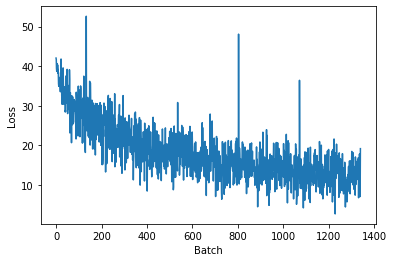

In [95]:
sns.lineplot(batches2plot, losses2plot).set(xlabel='Batch', ylabel='Loss')